In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.misc import toimage
from tensorflow.keras.datasets import mnist

In [0]:
from tensorflow.keras.utils import to_categorical

# TensorBoardColab

TensorBoardというtensorflowベースのエンジンを使っている場合に、学習ヒストリやネットワークのグラフなどを確認できるツールをcolabから使えるようにするもの。

In [8]:
!pip install tensorboardcolab
from tensorboardcolab import *


Using TensorFlow backend.


In [9]:
tbc = TensorBoardColab()
summary_writer = tbc.get_writer()

Wait for 8 seconds...
TensorBoard link:
https://2282f099.ngrok.io


# 学習データ準備

In [0]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

x_train = X_train.astype('float32')
x_test = X_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = to_categorical(Y_train, 10)
y_test = to_categorical(Y_test, 10)

In [0]:
import cv2

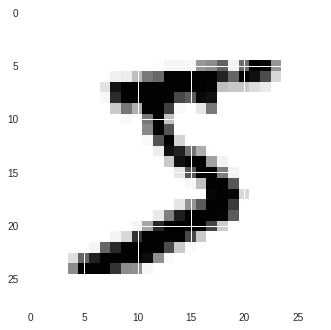

In [8]:
plt.imshow(X_train[0])

In [0]:
img = cv2.resize(X_train[0], (28,28))

In [0]:
def affine_image(img, x, y, angle, scale=1.0):
  w = 28
  h = 28

  center = (w/2, h/2)
  rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)

  # 平行移動して(x, y)の位置に置く
  affine_matrix = rotation_matrix.copy()
  affine_matrix[0][2] = affine_matrix[0][2] - w/2 + x
  affine_matrix[1][2] = affine_matrix[1][2] - h/2 + y

  img_rot = cv2.warpAffine(img, affine_matrix, (w, h), flags=cv2.INTER_CUBIC)

  return img_rot

In [0]:
img_rot = affine_image(img, 8, 8, 0, 0.8)

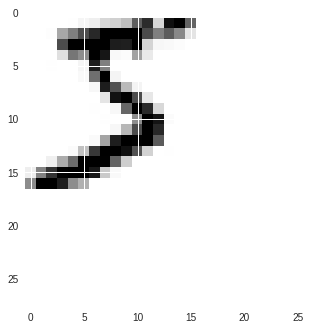

In [0]:
plt.imshow(img_rot)

# 小さなCNN

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam

In [0]:
model = Sequential()

model.add(Conv2D(100, 3, padding='same', input_shape=(28, 28, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(200, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(200, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(200, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(200, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(200))

model.add(Dense(10))
model.add(Activation('softmax'))

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(momentum=0.9, nesterov=True),
              metrics=['accuracy'])


In [0]:
import os
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.19.184.202:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2042703823478942447)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11437009436083969393)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 5855631250713975829)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 15865175564536549733)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 14307886007535200058)
INFO:tensorflow:*** Available Device: _Devi

In [0]:
tpu_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    metrics=['categorical_accuracy'])


In [0]:
tpu_model.fit(
    x=x_train.reshape(60000, 28, 28, 1), y=y_train,
    batch_size=1000, epochs=5,
    validation_data=(x_test.reshape(10000, 28, 28, 1), y_test)
)


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(125,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(125, 28, 28, 1), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(125, 10), dtype=tf.float32, name='activation_5_target_50')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 4.446039915084839 secs
INFO:tensorflow:Setting weights on TPU model.
59000/60000 [============================>.] - ETA: 0s - loss: 2.5000 - categorical_accuracy: 0.8053INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(125,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(125, 28, 28, 1), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(125, 10), dtype=tf.float32, name='activation_5_target_50'

In [0]:
cpu_model = tpu_model.sync_to_cpu()

INFO:tensorflow:Copying TPU weights to the CPU


In [0]:
def test_mnist_cnn(x_test, y_test):
    test_num = 10
    start = np.random.randint(x_test.shape[0] - test_num)
    x = x_test[start:start+test_num]
    y = y_test[start:start+test_num]

    fig, subplts = plt.subplots(ncols=10, figsize=(20, 2))
    for i in range(10):
        subplts[i].imshow(x[i])

    print(np.argmax(y, axis=1))

    preds = cpu_model.predict(x.reshape(test_num,28,28,1))
    print(np.argmax(preds, axis=1))

[6 8 2 4 6 7 9 3 3 9]
[4 8 1 1 6 1 9 1 8 9]


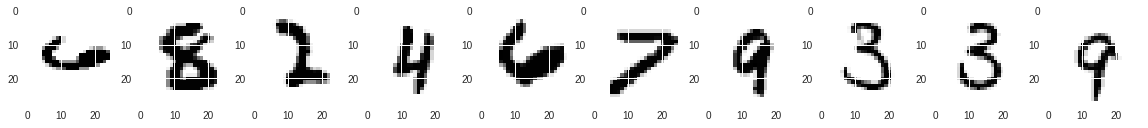

In [0]:
test_mnist_cnn(x_test, y_test)

In [0]:
import math
def test2_mnist_cnn(scale=0.5):
    size = 28
    test_num = 10
    x  = np.zeros((test_num, size, size), dtype = 'float32')
    start = np.random.randint(x_test.shape[0] - test_num)
    x_orig = x_test[start:start+test_num]
    y = y_test[start:start+test_num]
    for i in range(10):
      padding_size = math.floor(size - size*scale)
      x0 = np.random.randint(padding_size) - math.floor(padding_size/2) + math.floor(size/2) 
      y0 = np.random.randint(padding_size) - math.floor(padding_size/2) + math.floor(size/2)
      #x[i] = affine_image(x_orig[i], x0, y0, 0, scale)
      x[i] = affine_image(x_orig[i], 10, 10, 0, scale)

    fig, subplts = plt.subplots(ncols=10, figsize=(20, 2))
    for i in range(10):
        subplts[i].imshow(x[i])

    print(np.argmax(y, axis=1))

    preds = cpu_model.predict(x.reshape(test_num,28,28,1))
    print(np.argmax(preds, axis=1))

[8 9 6 4 2 6 4 7 5 5]
[1 1 1 1 1 1 1 1 1 1]


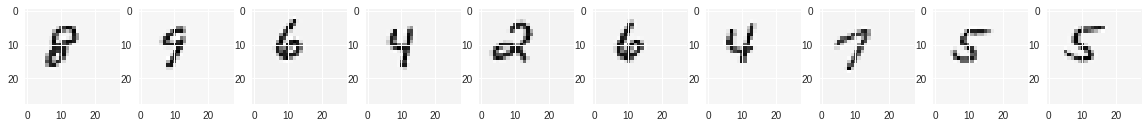

In [0]:
test2_mnist_cnn(0.6)

In [0]:
def test3_mnist_cnn(scale=0.8):
    size = 28
    test_num = 10
    x  = np.zeros((test_num, size, size), dtype = 'float32')
    start = np.random.randint(x_test.shape[0] - test_num)
    x_orig = x_test[start:start+test_num]
    y = y_test[start:start+test_num]
    for i in range(10):
      padding_size = math.floor(size - size*scale)
      x0 = np.random.randint(padding_size) - math.floor(padding_size/2) + math.floor(size/2) 
      y0 = np.random.randint(padding_size) - math.floor(padding_size/2) + math.floor(size/2)
      x[i] = affine_image(x_orig[i], x0, y0, 0, scale)

    fig, subplts = plt.subplots(ncols=10, figsize=(20, 2))
    for i in range(10):
        subplts[i].imshow(x[i])


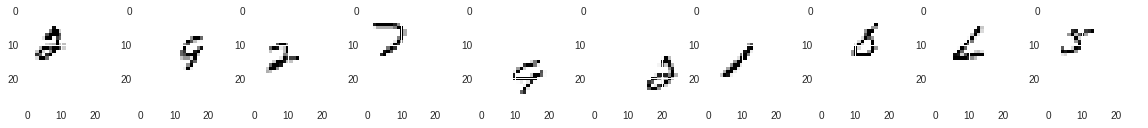

In [0]:
test3_mnist_cnn(0.5)

In [0]:
def make_train_mnist(X_orig):
  size = 28
  num = X_orig.shape[0]
  affined_x = np.zeros((num, size, size), dtype = 'float32')
  for i in range(num):
    scale = 1.0 - np.random.rand()*0.6 # scale = 0.0 ... 0.6
    padding_size = math.floor(size - size*scale)
    if padding_size >= 1:
      x0 = np.random.randint(padding_size) - math.floor(padding_size/2) + math.floor(size/2) 
      y0 = np.random.randint(padding_size) - math.floor(padding_size/2) + math.floor(size/2)
    else:
      x0 = math.floor(size/2) 
      y0 = math.floor(size/2) 
    affined_x[i] = affine_image(X_orig[i], x0, y0, 0, scale)
  return affined_x

In [0]:
affined_x_train = make_train_mnist(x_train)
affined_x_test = make_train_mnist(x_test)

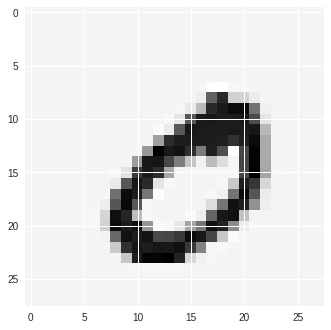

In [0]:
plt.imshow(affined_x_train[119])

In [0]:
affined_x_train = make_train_mnist(x_train)
affined_x_test = make_train_mnist(x_test)

tpu_model.fit(
    x=affined_x_train.reshape(60000, 28, 28, 1), y=y_train,
    batch_size=1000, epochs=2,
    validation_data=(affined_x_test.reshape(10000, 28, 28, 1), y_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 120us/step - loss: 0.8776 - categorical_accuracy: 0.8829 - val_loss: 5.4546 - val_categorical_accuracy: 0.2905
Epoch 2/2
60000/60000 [==============================] - 7s 116us/step - loss: 0.2057 - categorical_accuracy: 0.9598 - val_loss: 0.6504 - val_categorical_accuracy: 0.7768


In [0]:
cpu_model = tpu_model.sync_to_cpu()

INFO:tensorflow:Copying TPU weights to the CPU


[7 5 4 0 8 9 9 1 0 5]
[9 5 4 0 8 9 9 1 6 6]


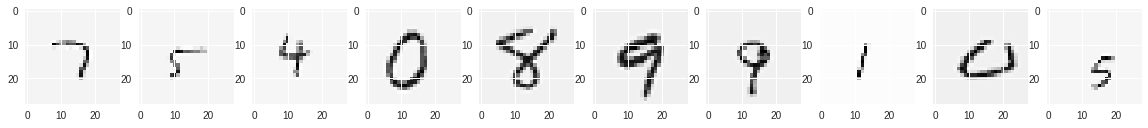

In [0]:
test_mnist_cnn(affined_x_test, y_test)

# AEを作る

https://qiita.com/koshian2/items/603106c228ac6b7d8356
のU-Netで作る

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from scipy.misc import toimage
from tensorflow.keras.datasets import mnist

In [0]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

x_train = X_train.astype('float32')
x_test = X_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = to_categorical(Y_train, 10)
y_test = to_categorical(Y_test, 10)

In [0]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input, Concatenate, MaxPool2D, Conv2DTranspose, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, History
import tensorflow.keras.backend as K
from keras.objectives import mean_squared_error
import os, tarfile, shutil, pickle
from PIL import Image

In [0]:
def create_block(input, depth):
    x = input
    for i in range(2):
        x = Conv2D(depth, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

def create_autoencoder():
    input = Input((28,28,1))
    # Encoder
    block1 = create_block(input, 32)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 64)
    x = MaxPool2D(2)(block2)
    block3 = create_block(x, 128)
    # Middle
    x = create_block(block3, 256)
    # Decoder
    x = Conv2DTranspose(128, kernel_size=2, strides=2)(x) # TPUだとUpsamplingやK.resize_imageが使えない
    x = create_block(x, 128)
    x = Conv2DTranspose(64, kernel_size=2, strides=2)(x)
    x = create_block(x, 64)
    # output
    x = Conv2D(1, 1)(x)
    x = Activation("sigmoid")(x)

    return Model(input, x)

def loss_function(y_true, y_pred):
    mses = mean_squared_error(y_true, y_pred)
    return K.sum(mses, axis=1)


In [0]:
class SamplingCallback(Callback):
    def __init__(self, model, predict_images, output_dir):
        self.model = model
        self.predict_images = (predict_images[:128] / 255.0).astype(np.float32) #128の倍数にする
        self.output_dir = output_dir
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)
        os.mkdir(output_dir)

    def combine_images(self, preds):
        ny, nx, nc = preds.shape[1:]
        combined = np.zeros((ny*10, nx*10, nc), dtype=np.float32)

        for i in range(preds.shape[0]):
            col_i = i % 10
            row_i = i // 10
            combined[row_i*ny:(row_i+1)*ny, col_i*nx:(col_i+1)*nx, :] = preds[i,:,:,:]
        combined = (combined*255.0).astype(np.uint8)
        return combined

    def on_train_begin(self, logs):
        combined = self.combine_images(self.predict_images[:100])
        with Image.fromarray(combined) as img:
            img.save(f"{self.output_dir}/groundtruth.png")

    def on_epoch_end(self, epoch, logs):
        preds = self.model.predict(self.predict_images)[:100]
        combined = self.combine_images(preds)
        with Image.fromarray(combined) as img:
            img.save(f"{self.output_dir}/epoch_{epoch:03}.png")


In [0]:
model = create_autoencoder()
model.compile(tf.train.MomentumOptimizer(1e-3, 0.9), loss=loss_function)

#cb = SamplingCallback(model, x_test[::23][:128].reshape(128, 28, 28, 1), "./autoencoder")
hist = History()

#tpu_model.fit_generator(generator(X_all, 256), steps_per_epoch=X_all.shape[0]//256, callbacks=[cb, hist], epochs=5)

# save_result
#with open("./autoencoder/history.dat", "wb") as fp:
#    pickle.dump(hist.history, fp)


In [0]:
model.fit(
    x=x_train[:100].reshape(100, 28, 28, 1), y=x_train[:100].reshape(100, 28, 28, 1),
    batch_size=10, epochs=2,
)

Epoch 1/2
100/100 [==============================] - 4s 37ms/step - loss: 6.3754
Epoch 2/2
100/100 [==============================] - 1s 10ms/step - loss: 1.6994


In [0]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

tpu_model.compile(tf.train.MomentumOptimizer(1e-3, 0.9), loss=loss_function)

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.65.187.194:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 18117727418535207819)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8959488799339822657)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 9126152005319478164)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 5769335252021653343)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 18304582892824941713)
INFO:tensorflow:*** Available Device: _Devic

In [0]:
cb = SamplingCallback(model, x_test[::23][:10].reshape(10, 28, 28, 1), "./autoencoder")
hist = History()

In [0]:
tpu_model.fit(
    x=x_train.reshape(60000, 28, 28, 1), y=x_train.reshape(60000, 28, 28, 1),
    #callbacks=[cb, hist],
    callbacks=[hist],
    batch_size=2048, epochs=10
)


Epoch 1/10
60000/60000 [==============================] - 8s 134us/step - loss: 0.2448
Epoch 2/10
60000/60000 [==============================] - 8s 134us/step - loss: 0.2350
Epoch 3/10
60000/60000 [==============================] - 8s 134us/step - loss: 0.2266
Epoch 4/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.2194
Epoch 5/10
60000/60000 [==============================] - 8s 134us/step - loss: 0.2127
Epoch 6/10
60000/60000 [==============================] - 8s 133us/step - loss: 0.2067
Epoch 7/10
60000/60000 [==============================] - 8s 135us/step - loss: 0.2015
Epoch 8/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.1966
Epoch 9/10
60000/60000 [==============================] - 8s 132us/step - loss: 0.1924
Epoch 10/10
60000/60000 [==============================] - 8s 140us/step - loss: 0.1882


In [0]:
# save_result
with open("./autoencoder/history.dat", "wb") as fp:
    pickle.dump(hist.history, fp)


In [0]:
!ls -l ./autoencoder

total 4
-rw-r--r-- 1 root root 335 Dec  6 06:41 history.dat


In [0]:
class SamplingCallback(Callback):
  def __init__(self, model, predict_images, output_dir):
    self.model = model
    self.predict_images = (predict_images[:128] / 255.0).astype(np.float32) #128の倍数にする
    self.output_dir = output_dir
    if os.path.exists(output_dir):
      shutil.rmtree(output_dir)
    os.mkdir(output_dir)

  def combine_images(self, preds):
    ny, nx, nc = preds.shape[1:]
    combined = np.zeros((ny*10, nx*10, nc), dtype=np.float32)

    for i in range(preds.shape[0]):
      col_i = i % 10
      row_i = i // 10
      combined[row_i*ny:(row_i+1)*ny, col_i*nx:(col_i+1)*nx, :] = preds[i,:,:,:]
    combined = (combined*255.0).astype(np.uint8)
    return combined

  def on_train_begin(self, logs):
    pass

  def on_epoch_end(self, epoch, logs):
    preds = self.model.predict(self.predict_images)[:100]
    self.output_sample_image(preds)

  def output_sample_image(x):
    test_num = 10
    size = x.shape[1:3]
    fig, subplts = plt.subplots(ncols=test_num, figsize=(20, 2))
    for i in range(test_num):
      subplts[i].imshow(x[i].reshape(size))


In [0]:
def print_image(x):
    size = x.shape[1:3]
    test_num = 10
    fig, subplts = plt.subplots(ncols=test_num, figsize=(20, 2))
    for i in range(test_num):
        subplts[i].imshow(x[i].reshape(size))

def test_ae(x):
  test_num = 10
  w = x.shape[1]
  h = x.shape[2]
  x_test = x[::23][:test_num].reshape(test_num, w, h, 1)
  print_image(x_test)
  
  cpu_model = tpu_model.sync_to_cpu()
  preds = cpu_model.predict(x_test)
  print_image(preds)


INFO:tensorflow:Copying TPU weights to the CPU


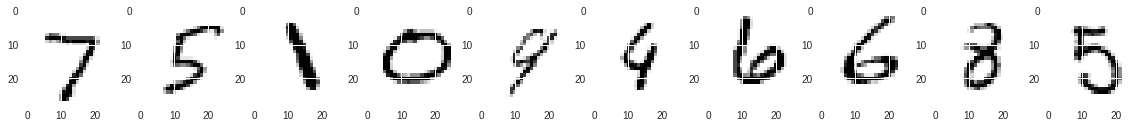

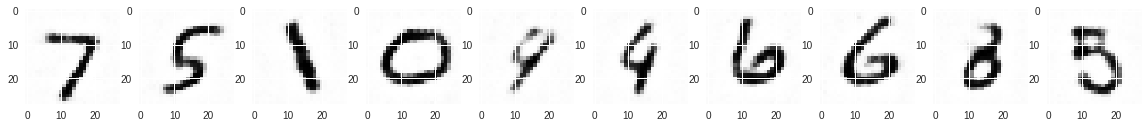

In [0]:
test_ae(x_test)

## エンコーダだけ別で使えるようにして判定機を作る

In [0]:
from tensorflow.keras.layers import Dense, Flatten

In [0]:
# encoder
input = Input((28,28,1))
block1 = create_block(input, 32)
x = MaxPool2D(2)(block1)
block2 = create_block(x, 64)
x = MaxPool2D(2)(block2)
block3 = create_block(x, 128)
encoded = create_block(block3, 256)
encoder = Model(input, encoded)

# validator
x = Flatten()(encoded)
x = Dense(100)(x)
validated = Dense(10)(x)
validator = Model(input, validated)

# decoder
x = Conv2DTranspose(128, kernel_size=2, strides=2)(encoded) # TPUだとUpsamplingやK.resize_imageが使えない
x = create_block(x, 128)
x = Conv2DTranspose(64, kernel_size=2, strides=2)(x)
x = create_block(x, 64)
x = Conv2D(1, 1)(x)
autoencoded = Activation("sigmoid")(x)
autoencoder = Model(input, autoencoded)


In [0]:
autoencoder.compile(tf.train.MomentumOptimizer(1e-3, 0.9), loss=loss_function)

In [0]:
autoencoder.fit(
    x=x_train[:100].reshape(100, 28, 28, 1), y=x_train[:100].reshape(100, 28, 28, 1),
    batch_size=10, epochs=1,
)

Epoch 1/1
100/100 [==============================] - 7s 74ms/step - loss: 5.3125


In [0]:
validator.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    metrics=['categorical_accuracy'])

In [0]:
validator.fit(
    x=x_train[:100].reshape(100, 28, 28, 1),
    y=y_train[:100],
    batch_size=10, epochs=1,
)

Epoch 1/1
100/100 [==============================] - 20s 204ms/step - loss: 4.0313 - categorical_accuracy: 0.0500


In [0]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    autoencoder,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

tpu_model.compile(tf.train.MomentumOptimizer(1e-3, 0.9), loss=loss_function)

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.65.187.194:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 18117727418535207819)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8959488799339822657)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 9126152005319478164)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 5769335252021653343)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 18304582892824941713)
INFO:tensorflow:*** Available Device: _Devic

In [0]:
tpu_model.fit(
    x=x_train.reshape(60000, 28, 28, 1), y=x_train.reshape(60000, 28, 28, 1),
    #callbacks=[cb, hist],
    callbacks=[hist],
    batch_size=2048, epochs=10
)

Epoch 1/10
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(256,), dtype=tf.int32, name='core_id_20'), TensorSpec(shape=(256, 28, 28, 1), dtype=tf.float32, name='input_7_10'), TensorSpec(shape=(256, 28, 28, 1), dtype=tf.float32, name='activation_80_target_50')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_7
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 21.282630443572998 secs
INFO:tensorflow:Setting weights on TPU model.
57344/60000 [===========================>..] - ETA: 2s - loss: 1.7803INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(76,), dtype=tf.int32, name='core_id_20'), TensorSpec(shape=(76, 28, 28, 1), dtype=tf.float32, name='input_7_10'), TensorSpec(shape=(76, 28, 28, 1), dtype=tf.float32, name='activation_80_target_50')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping p

In [0]:
tpu_validator_model = tf.contrib.tpu.keras_to_tpu_model(
    validator,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

tpu_validator_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    metrics=['categorical_accuracy'])

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.65.187.194:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 18117727418535207819)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8959488799339822657)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 9126152005319478164)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 5769335252021653343)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 18304582892824941713)
INFO:tensorflow:*** Available Device: _Devic

In [0]:
tpu_validator_model.fit(
    x=x_train.reshape(60000, 28, 28, 1),
    y=y_train,
    callbacks=[hist],
    batch_size=2048, epochs=10
)

Epoch 1/10
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(256,), dtype=tf.int32, name='core_id_50'), TensorSpec(shape=(256, 28, 28, 1), dtype=tf.float32, name='input_8_10'), TensorSpec(shape=(256, 10), dtype=tf.float32, name='dense_3_target_60')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_8
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 32.446099281311035 secs
INFO:tensorflow:Setting weights on TPU model.
57344/60000 [===========================>..] - ETA: 2s - loss: 8.9063 - categorical_accuracy: 0.1039INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(76,), dtype=tf.int32, name='core_id_50'), TensorSpec(shape=(76, 28, 28, 1), dtype=tf.float32, name='input_8_10'), TensorSpec(shape=(76, 10), dtype=tf.float32, name='dense_3_target_60')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapp

In [0]:
import math
def test_autoencoder_validator(scale=0.5):
    size = 28
    test_num = 10
    x  = np.zeros((test_num, size, size), dtype = 'float32')
    start = np.random.randint(x_test.shape[0] - test_num)
    x_orig = x_test[start:start+test_num]
    y = y_test[start:start+test_num]
    for i in range(10):
      padding_size = math.floor(size - size*scale)
      x0 = np.random.randint(padding_size) - math.floor(padding_size/2) + math.floor(size/2) 
      y0 = np.random.randint(padding_size) - math.floor(padding_size/2) + math.floor(size/2)
      #x[i] = affine_image(x_orig[i], x0, y0, 0, scale)
      x[i] = affine_image(x_orig[i], 10, 10, 0, scale)

    fig, subplts = plt.subplots(ncols=10, figsize=(20, 2))
    for i in range(10):
        subplts[i].imshow(x[i])

    print(np.argmax(y, axis=1))

    cpu_model = tpu_validator_model.sync_to_cpu()
    preds = cpu_model.predict(x.reshape(test_num,28,28,1))
    print(np.argmax(preds, axis=1))


[3 6 0 2 7 6 6 1 2 8]
INFO:tensorflow:Copying TPU weights to the CPU
[3 3 3 3 3 3 3 3 3 3]


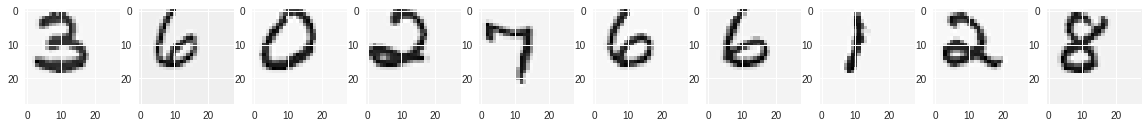

In [0]:
test_autoencoder_validator(0.9)

In [0]:
tpu_model.fit(
    x=x_train.reshape(60000, 28, 28, 1), y=x_train.reshape(60000, 28, 28, 1),
    callbacks=[TensorBoardColabCallback(tbc)],
    batch_size=2048, epochs=10
)

Epoch 1/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.1603
Epoch 2/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.1582
Epoch 3/10
60000/60000 [==============================] - 8s 132us/step - loss: 0.1564
Epoch 4/10
60000/60000 [==============================] - 8s 133us/step - loss: 0.1546
Epoch 5/10
60000/60000 [==============================] - 8s 130us/step - loss: 0.1528
Epoch 6/10
60000/60000 [==============================] - 8s 133us/step - loss: 0.1512
Epoch 7/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.1497
Epoch 8/10
60000/60000 [==============================] - 8s 135us/step - loss: 0.1480
Epoch 9/10
60000/60000 [==============================] - 8s 134us/step - loss: 0.1465
Epoch 10/10
60000/60000 [==============================] - 8s 130us/step - loss: 0.1451


# 32x32にしてサイズを変えたテストデータで学習

# ResNetで普通に学習させてbaselineにする

In [0]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input, Concatenate, MaxPool2D, Conv2DTranspose, Add, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, History
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mean_squared_error
import os
from PIL import Image

In [0]:
input = Input((28,28,1))

x = Conv2D(32, 3, padding="same")(input)
x = Activation("relu")(x)
x = BatchNormalization()(x)

x = Conv2D(32, 3, padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)

x = MaxPool2D(2)(x)

x = Conv2D(64, 3, padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)

x = Conv2D(64, 3, padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)

x = MaxPool2D(2)(x)

x = Conv2D(128, 3, padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)

x = Conv2D(128, 3, padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(200)(x)
x = Activation("relu")(x)
x = Dense(10)(x)
predictions = Activation("sigmoid")(x)

validator = Model(input, predictions)

In [0]:
# activationとbatchnormalizationの順番入れ替えたパターン
input = Input((28,28,1))

x = Conv2D(32, 3, padding="same")(input)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(32, 3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = MaxPool2D(2)(x)

x = Conv2D(64, 3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(64, 3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = MaxPool2D(2)(x)

x = Conv2D(128, 3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(128, 3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Flatten()(x)
x = Dense(200, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

validator = Model(input, predictions)

In [0]:
input = Input((28,28,1))

x = Conv2D(100, 3, padding='same')(input)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

x = MaxPool2D(pool_size=(2, 2))(x)

x = Conv2D(200, 3, padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

x = Conv2D(200, 3, padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

x = MaxPool2D(pool_size=(2, 2))(x)

x = Conv2D(200, 3, padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

x = Conv2D(200, 3, padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

x = Flatten()(x)

x = Dense(200, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

validator = Model(input, predictions)

In [0]:
def make_encoder(input):
  x = Conv2D(32, 3, padding="same")(input)
  x = Activation("relu")(x)
  x = BatchNormalization()(x)

  x = Conv2D(32, 3, padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization()(x)

  x = MaxPool2D(2)(x)

  x = Conv2D(64, 3, padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization()(x)

  x = Conv2D(64, 3, padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization()(x)

  x = MaxPool2D(2)(x)

  x = Conv2D(128, 3, padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization()(x)

  x = Conv2D(128, 3, padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization()(x)

  model = Model(input, x)
  
  return model

In [0]:
def make_classifier(input):
  x = Flatten()(input)
  x = Dense(200)(x)
  x = Activation("relu")(x)
  x = Dense(10)(x)
  x = Activation("sigmoid")(x)
  model = Model(input, x)
  return model

In [0]:
input = Input((28,28,1))
encoder = make_encoder(input)
x = Flatten()(encoder.layers[-1].output)
x = Dense(200)(x)
x = Activation("relu")(x)
x = Dense(10)(x)
x = Activation("sigmoid")(x)
validator = Model(encoder.inputs, x)

#classifier = make_classifier(encoder)
#validator = Model(
#    inputs=encoder.input,
#    outputs=classifier.output)

In [0]:
encoder.output

<tf.Tensor 'batch_normalization_59/FusedBatchNorm:0' shape=(?, 7, 7, 128) dtype=float32>

In [0]:
input = Input((28,28,1))
encoder = make_encoder(input_tensor=input)
classifier_input = Input(shape=encoder.output_shape[1:])
x = Flatten()(classifier_input)
x = Dense(200)(x)
x = Activation("relu")(x)
x = Dense(10)(x)
x = Activation("sigmoid")(x)
validator = Model(
    inputs=encoder.input,
    outputs=classifier(encoder.output))

In [0]:
validator.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    metrics=['categorical_accuracy'])

In [0]:
validator.save_weights('my_model_weights.h5')

In [15]:
validator.fit(
    x=x_train[:1000].reshape(1000, 28, 28, 1),
    y=y_train[:1000],
    batch_size=100, epochs=1,
    #callbacks=[TensorBoardColabCallback(tbc)],
    #validation_data=(x_test[:100].reshape(100, 28, 28, 1), y_test[:100])
)

Epoch 1/1
1000/1000 [==============================] - 12s 12ms/step - loss: 1.1548 - categorical_accuracy: 0.6450


In [0]:
validator.load_weights('my_model_weights.h5')

In [22]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    validator,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

tpu_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    metrics=['categorical_accuracy'])

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.43.198.202:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 7321861937527409554)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 12535145989370964041)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 5166179787055120119)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9614282540622008967)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 11963628341253245733)
INFO:tensorflow:*** Available Device: _Devic

In [0]:
hist = History()

In [24]:
tpu_model.fit(
    x=x_train.reshape(60000, 28, 28, 1), y=y_train,
    callbacks=[TensorBoardColabCallback(tbc)],
    batch_size=1024, epochs=3
)

Epoch 1/3
60000/60000 [==============================] - 6s 96us/step - loss: 0.0183 - categorical_accuracy: 0.9952
Epoch 2/3
60000/60000 [==============================] - 6s 95us/step - loss: 0.0131 - categorical_accuracy: 0.9962
Epoch 3/3
60000/60000 [==============================] - 6s 96us/step - loss: 0.0086 - categorical_accuracy: 0.9978


In [0]:
import math
def test_validator(scale=0.5):
    size = 28
    test_num = 10
    x  = np.zeros((test_num, size, size), dtype = 'float32')
    start = np.random.randint(x_test.shape[0] - test_num)
    x_orig = x_test[start:start+test_num]
    y = y_test[start:start+test_num]
    for i in range(10):
      padding_size = math.floor(size - size*scale)
      x0 = np.random.randint(padding_size) - math.floor(padding_size/2) + math.floor(size/2) 
      y0 = np.random.randint(padding_size) - math.floor(padding_size/2) + math.floor(size/2)
      #x[i] = affine_image(x_orig[i], x0, y0, 0, scale)
      x[i] = affine_image(x_orig[i], 10, 10, 0, scale)

    fig, subplts = plt.subplots(ncols=10, figsize=(20, 2))
    for i in range(10):
        subplts[i].imshow(x[i])

    print(np.argmax(y, axis=1))

    cpu_model = tpu_model.sync_to_cpu()
    preds = cpu_model.predict(x.reshape(test_num,28,28,1))
    print(np.argmax(preds, axis=1))


[1 9 8 9 2 3 5 5 9 4]
INFO:tensorflow:Copying TPU weights to the CPU
[5 5 5 5 5 5 5 5 5 5]


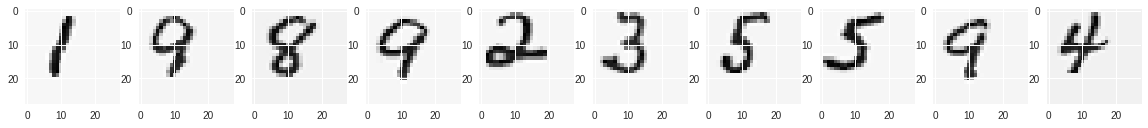

In [0]:
test_validator(0.9)

# VAEサンプル

https://blog.keras.io/building-autoencoders-in-keras.html


In [0]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input, Concatenate, MaxPool2D, Conv2DTranspose, Add, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, History
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mean_squared_error
import os
from PIL import Image

In [0]:
expression_dim = 30

#input = Input((28,28,1))
input = Input(shape=(784,))

x = Dense(expression_dim)(input)
encoded = Activation('relu')(x)

x = Dense(784)(encoded)
decoded = Activation('sigmoid')(x)
autoencoder = Model(input, decoded)

encoder = Model(input, encoded)

In [0]:
expression_input = Input((expression_dim,))
decoder_layer = autoencoder.layers[-1] # 最後のレイヤー1層がdecoder
decoder = Model(expression_input, decoder_layer(expression_input))

In [0]:
autoencoder.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ))

In [0]:
x_train_flatten = x_train.reshape(60000, 784)
x_test_flatten = x_test.reshape(10000, 784)

In [60]:
autoencoder.fit(
    x=x_train_flatten, y=x_train_flatten,
    epochs=1)

Epoch 1/1
60000/60000 [==============================] - 12s 199us/step - loss: 0.1082


In [7]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    autoencoder,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

tpu_model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ))

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.32.74.10:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 11590439381290850286)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 13471779200105244428)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 11072163633374787605)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16645369205575527650)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 12354500239125362269)
INFO:tensorflow:*** Available Device: _Devi

AttributeError: ignored

In [0]:
def make_encoder():
  input = Input((28,28,1))
  x = Dense(30)(input)
  return Model(input, x)

def make_decoder(dim):
  input = Input(30)
  x = Dense((28,28,1))(input)
  return Model(input, x)


# LSTMサンプル

https://keras.io/getting-started/functional-api-guide/

In [13]:
import tensorflow.keras
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

tweet_a = Input(shape=(280, 256))
tweet_b = Input(shape=(280, 256))

# This layer can take as input a matrix
# and will return a vector of size 64
shared_lstm = LSTM(64)

# When we reuse the same layer instance
# multiple times, the weights of the layer
# are also being reused
# (it is effectively *the same* layer)
encoded_a = shared_lstm(tweet_a)
encoded_b = shared_lstm(tweet_b)

# We can then concatenate the two vectors:
merged_vector = keras.layers.concatenate([encoded_a, encoded_b], axis=-1)

# And add a logistic regression on top
predictions = Dense(1, activation='sigmoid')(merged_vector)

# We define a trainable model linking the
# tweet inputs to the predictions
model = Model(inputs=[tweet_a, tweet_b], outputs=predictions)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#model.fit([data_a, data_b], labels, epochs=10)


AttributeError: ignored

In [26]:
print(tensorflow.keras.__version__)

2.1.6-tf


In [27]:
import keras
print(keras.__version__)

2.2.4


# GANサンプル

In [14]:
!git clone https://github.com/bstriner/keras_adversarial.git

Cloning into 'keras_adversarial'...
remote: Enumerating objects: 506, done.
remote: Total 506 (delta 0), reused 0 (delta 0), pack-reused 506
Receiving objects: 100% (506/506), 5.14 MiB | 21.77 MiB/s, done.
Resolving deltas: 100% (318/318), done.


In [15]:
!(cd keras_adversarial; python setup.py install)

running install
running bdist_egg
running egg_info
creating keras_adversarial.egg-info
writing keras_adversarial.egg-info/PKG-INFO
writing dependency_links to keras_adversarial.egg-info/dependency_links.txt
writing requirements to keras_adversarial.egg-info/requires.txt
writing top-level names to keras_adversarial.egg-info/top_level.txt
writing manifest file 'keras_adversarial.egg-info/SOURCES.txt'
reading manifest file 'keras_adversarial.egg-info/SOURCES.txt'
writing manifest file 'keras_adversarial.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/keras_adversarial
copying keras_adversarial/image_grid_callback.py -> build/lib/keras_adversarial
copying keras_adversarial/__init__.py -> build/lib/keras_adversarial
copying keras_adversarial/unrolled_optimizer.py -> build/lib/keras_adversarial
copying keras_adversarial/adversarial_utils.py -> build/lib/keras_adversarial
co

In [19]:
!pip install git+https://github.com/bstriner/keras-adversarial.git

  Cloning https://github.com/bstriner/keras-adversarial.git to /tmp/pip-req-build-zzzxc8tc
  Running setup.py bdist_wheel for keras-adversarial ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-jdvh0ory/wheels/f4/34/ba/6041a92244597803d1f8954d649e7899d011d46f33c02dc476
Successfully built keras-adversarial


In [20]:
from keras_adversarial import AdversarialModel, simple_gan, gan_targets

ImportError: ignored

In [16]:
adversarial_model = AdversarialModel(base_model=M, player_params=[generator.trainable_weights, discriminator.trainable_weights], player_names=["generator", "discriminator"])

NameError: ignored

In [22]:
import matplotlib as mpl

# This line allows mpl to run with no DISPLAY defined
mpl.use('Agg')

import pandas as pd
import numpy as np
import os
from keras.layers import Reshape, Flatten, LeakyReLU, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras_adversarial.image_grid_callback import ImageGridCallback
from keras_adversarial import AdversarialModel, simple_gan, gan_targets
from keras_adversarial import normal_latent_sampling, AdversarialOptimizerSimultaneous
from keras_adversarial.legacy import l1l2, Dense, fit
import keras.backend as K
from mnist_utils import mnist_data


def model_generator(latent_dim, input_shape, hidden_dim=1024, reg=lambda: l1l2(1e-5, 1e-5)):
    return Sequential([
        Dense(int(hidden_dim / 4), name="generator_h1", input_dim=latent_dim, W_regularizer=reg()),
        LeakyReLU(0.2),
        Dense(int(hidden_dim / 2), name="generator_h2", W_regularizer=reg()),
        LeakyReLU(0.2),
        Dense(hidden_dim, name="generator_h3", W_regularizer=reg()),
        LeakyReLU(0.2),
        Dense(np.prod(input_shape), name="generator_x_flat", W_regularizer=reg()),
        Activation('sigmoid'),
        Reshape(input_shape, name="generator_x")],
        name="generator")


def model_discriminator(input_shape, hidden_dim=1024, reg=lambda: l1l2(1e-5, 1e-5), output_activation="sigmoid"):
    return Sequential([
        Flatten(name="discriminator_flatten", input_shape=input_shape),
        Dense(hidden_dim, name="discriminator_h1", W_regularizer=reg()),
        LeakyReLU(0.2),
        Dense(int(hidden_dim / 2), name="discriminator_h2", W_regularizer=reg()),
        LeakyReLU(0.2),
        Dense(int(hidden_dim / 4), name="discriminator_h3", W_regularizer=reg()),
        LeakyReLU(0.2),
        Dense(1, name="discriminator_y", W_regularizer=reg()),
        Activation(output_activation)],
        name="discriminator")


def example_gan(adversarial_optimizer, path, opt_g, opt_d, nb_epoch, generator, discriminator, latent_dim,
                targets=gan_targets, loss='binary_crossentropy'):
    csvpath = os.path.join(path, "history.csv")
    if os.path.exists(csvpath):
        print("Already exists: {}".format(csvpath))
        return

    print("Training: {}".format(csvpath))
    # gan (x - > yfake, yreal), z generated on GPU
    gan = simple_gan(generator, discriminator, normal_latent_sampling((latent_dim,)))

    # print summary of models
    generator.summary()
    discriminator.summary()
    gan.summary()

    # build adversarial model
    model = AdversarialModel(base_model=gan,
                             player_params=[generator.trainable_weights, discriminator.trainable_weights],
                             player_names=["generator", "discriminator"])
    model.adversarial_compile(adversarial_optimizer=adversarial_optimizer,
                              player_optimizers=[opt_g, opt_d],
                              loss=loss)

    # create callback to generate images
    zsamples = np.random.normal(size=(10 * 10, latent_dim))

    def generator_sampler():
        return generator.predict(zsamples).reshape((10, 10, 28, 28))

    generator_cb = ImageGridCallback(os.path.join(path, "epoch-{:03d}.png"), generator_sampler)

    # train model
    xtrain, xtest = mnist_data()
    y = targets(xtrain.shape[0])
    ytest = targets(xtest.shape[0])
    callbacks = [generator_cb]
    if K.backend() == "tensorflow":
        callbacks.append(
            TensorBoard(log_dir=os.path.join(path, 'logs'), histogram_freq=0, write_graph=True, write_images=True))
    history = fit(model, x=xtrain, y=y, validation_data=(xtest, ytest), callbacks=callbacks, nb_epoch=nb_epoch,
                  batch_size=32)

    # save history to CSV
    df = pd.DataFrame(history.history)
    df.to_csv(csvpath)

    # save models
    generator.save(os.path.join(path, "generator.h5"))
    discriminator.save(os.path.join(path, "discriminator.h5"))


def main():
    # z \in R^100
    latent_dim = 100
    # x \in R^{28x28}
    input_shape = (28, 28)
    # generator (z -> x)
    generator = model_generator(latent_dim, input_shape)
    # discriminator (x -> y)
    discriminator = model_discriminator(input_shape)
    example_gan(AdversarialOptimizerSimultaneous(), "output/gan",
                opt_g=Adam(1e-4, decay=1e-4),
                opt_d=Adam(1e-3, decay=1e-4),
                nb_epoch=100, generator=generator, discriminator=discriminator,
                latent_dim=latent_dim)


if __name__ == "__main__":
  main()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_error
   

ModuleNotFoundError: ignored